In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import hemul
hemul.USE_FPGA=False
from hemul import heaan
from muxcnn.resnet_HEAAN import ResNetHEAAN
from muxcnn.utils import get_channel_last

from muxcnn.models.ResNet20 import ResNet, BasicBlock
from muxcnn.utils import load_params, load_img, decrypt_result
import struct

Using CPU version HEAAN
Using CPU version HEAAN
Using CPU version HEAAN


# 1. 원본 Pytorch 모델

In [2]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
import torch.nn.functional as F

num_workers = 0
batch_size = 32
valid_size = 0.2

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=train_transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=test_transform)

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# CIFAR-10 classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

model = ResNet(BasicBlock,[1,1,1])
model.eval() 

# Load trained parameters
load_params(model, fn_param="./ResNet8.pt",device='cpu')

## FHE Setup

In [4]:
logp = 40
logq = 800
logn = 15

# Rotation 미리 준비 
rot_l = [2**i for i in range(15)]
rot_l = rot_l + [2**15-1, 
                 2**15-33, 2**15-32, 2**15-31,
                 2**15-17, 2**15-16, 2**15-15, 
                 2**15-9,2**15-8, 2**15-7] + [3,5,7,9,15,17, 31, 33]

hec = heaan.HEAANContext(logn, logp, logq, load_keys=True, rot_l=rot_l)

Initializing the scheme as the data owner
Loading a secret key from:  ./SecretKey.txt
loading secret key done.
HEAAN CKKS setup is ready 


In [8]:
fhemodel = ResNetHEAAN(model, hec, alpha=14, min_depth=True)

function approximators set
degrees = [7, 7, 15, 15, 27], margin = 0.0005, eps = 0.01


### Pack and Encrypt the tensor image

In [9]:
for img_tensor, label in valid_loader:    
    print(img_tensor.shape, label)
    for i in range(32):
        ctxt = fhemodel.pack_img_ctxt(img_tensor[i:i+1,:,:,:])
        result = fhemodel(ctxt)

        class_num = decrypt_result(hec, result)
        print("[FHE_CNN] Inference result:", class_num)
        print(f"[FHE_CNN] It's a {classes[class_num]}, ANSWER:", label[i])
        
        del ctxt

torch.Size([32, 3, 32, 32]) tensor([9, 7, 3, 0, 5, 8, 0, 1, 5, 0, 0, 4, 1, 5, 2, 3, 0, 1, 0, 9, 0, 8, 7, 4,
        0, 2, 4, 1, 6, 3, 5, 9])
[FHE_CNN] Inference started...
[FHE_CNN_EARLY] ConvBN started...
[MultParConv] Layer structure: (hi,wi,ci,ki,ti,pi) =(32,32, 3, 1, 3,  8)
ct_d 40 720
[FHE_CNN_EARLY] ConvBN finished in 10.86 sec
[FHE_CNN_EARLY] ReLU started...
APPR 7 40 720
[ 0.72535563  0.07396074  0.29663535 ... -0.67000996 -0.67000973
 -0.454484  ]
min max -9.543108837309246 6.156781208800096
APPR 7 40 560
[ 0.09458583  0.00965537  0.03871797 ... -0.08738349 -0.08738346
 -0.05930565]
min max -1.019015256187269 0.7396998857976873
APPR 15 40 400
[ 0.40751528  0.04252408  0.16992775 ... -0.37771357 -0.37771345
 -0.25898398]
min max -1.1856622446216531 1.1856734944252572
APPR 15 40 200
[ 0.9124565   0.36677278  1.10877497 ... -0.94806298 -0.9480638
 -1.16094808]
min max -1.1809134518493376 1.1809142203567755
bootstrap done
AFTER bootstrap 40 800
APPR 27 40 600
[ 1.01677025  0.96840

KeyboardInterrupt: 

# 2. Cehck Ciphertext 

### 2.1. save Ciphertext to file

In [9]:
heaan.he.SerializationUtils.writeCiphertext(ctxt, "packed_img.dat")

### 2.2 Load using Python 

In [84]:
import struct

f = open("packed_img.dat", "rb")
encrypted_img = f.read()

data = struct.iter_unpack('l', encrypted_img[:8*3]) # Ctxt header
read_nslots, read_logp, read_logq = data

print("Ciphertext has the following FHE parameters:")
print("nslots, logp, logq  = ", read_nslots, read_logp, read_logq)

Ciphertext has the following FHE parameters:
nslots, logp, logq  =  (32768,) (40,) (800,)


### 2.3. Try to interpret encrypted data

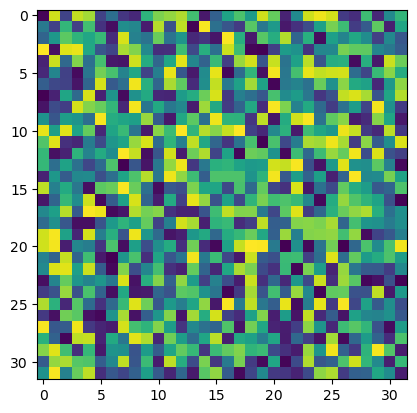

In [85]:
arr = np.frombuffer(encrypted_img[8*3:], dtype=np.int64)
reshaped = arr.reshape(32,32,-1)
plt.imshow(reshaped[:,:,0])

# 3. FHE model inference

In [ ]:
result = fhemodel(ctxt)

[FHE_CNN] Inference started...
[FHE_CNN_EARLY] ConvBN started...
[MultParConv] Layer structure: (hi,wi,ci,ki,ti,pi) =(32,32, 3, 1, 3,  8)
[FHE_CNN_EARLY] ConvBN finished in 33.48 sec
[FHE_CNN_EARLY] ReLU started...
bootstrap done
[FHE_CNN_EARLY] ReLU hinished in 61.43 sec
[FHE_CNN BasicBlock] ConvBN1 started...
[MultParConv] Layer structure: (hi,wi,ci,ki,ti,pi) =(32,32,16, 1,16,  2)
[FHE_CNN BasicBlock] ConvBN1 finished in 55.19 sec
[FHE_CNN BasicBlock] ReLU1 started...
bootstrap done
bootstrap done
[FHE_CNN BasicBlock] ReLU1 finished in 62.02 sec
[FHE_CNN BasicBlock] ConvBN2 started...
[MultParConv] Layer structure: (hi,wi,ci,ki,ti,pi) =(32,32,16, 1,16,  2)
[FHE_CNN BasicBlock] ConvBN2 finished in 55.97 sec
[FHE_CNN BasicBlock] ReLU2 started...
bootstrap done
bootstrap done
[FHE_CNN BasicBlock] ReLU2 finished in 61.26 sec
[FHE_CNN] First Basic Block finished in 234.51 sec

[FHE_CNN BasicBlock] ConvBN1 started...
[MultParConv] Layer structure: (hi,wi,ci,ki,ti,pi) =(32,32,16, 1,16,  2)


In [ ]:
class_num = decrypt_result(hec, result)
print("[FHE_CNN] Inference result:", class_num)
print(f"[FHE_CNN] It's a {classes[class_num]}")

### 3.1 Comparison with Pytorch result

In [ ]:
import torch
torch_result = model(img_tensor)
torch_class = torch.argmax(torch_result)
print(f"[PyTorch] It's a {classes[torch_class]}")